In [121]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
import matplotlib.pyplot as plt 

In [122]:
data_dir = "brain_tumor_dataset"

In [123]:
image_data = []
labels = []

In [124]:
# no path folder
no_tumor_dir = os.path.join(data_dir, 'no')
for filename in os.listdir(no_tumor_dir):
    if filename.endswith('.jpg'):
        image_data.append(os.path.join(no_tumor_dir, filename))
        labels.append(0)

# yes path folder
yes_tumor_dir = os.path.join(data_dir,'yes')
for filename in os.listdir(yes_tumor_dir):
    if filename.endswith('.jpg'):
        image_data.append(os.path.join(yes_tumor_dir, filename))
        labels.append(1)

In [125]:
print(f"total image found: {len(image_data)}")

total image found: 4432


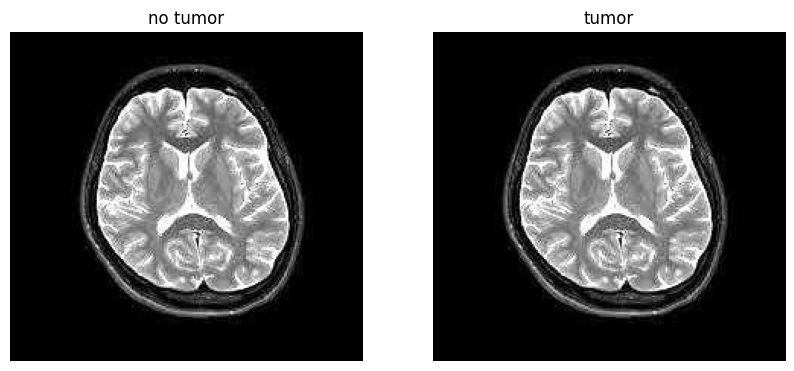

shape of the yes tumor sample: (217, 232, 3)
shape of the no  tumor sample: (217, 232, 3)


In [126]:
# display one image from each class
plt.figure(figsize = (10,5))
# display a "no tumor" image. 
no_tumor_sample = cv2.imread(image_data[0])
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(no_tumor_sample, cv2.COLOR_BGR2RGB))
plt.title('no tumor')
plt.axis('off')
# display a "yes tumor" image.
yes_tumor_sample = cv2.imread(image_data[0])
plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(yes_tumor_sample, cv2.COLOR_BGR2RGB))
plt.title('tumor')
plt.axis('off')

plt.show()
# print the image to see if they consistent or not
print(f'shape of the yes tumor sample: {yes_tumor_sample.shape}')
print(f'shape of the no  tumor sample: {no_tumor_sample.shape}')

In [127]:
# list to numpy conversion
image_data = np.array(image_data)   
labels = np.array(labels)
# split the data in training and validation
X_train, X_val, y_train, y_val = train_test_split(image_data, labels, test_size = 0.2, stratify = labels)


In [128]:
import torchvision.transforms as tf
data_tf = tf.Compose([
    tf.ToPILImage(),
    tf.Resize((244,244)),
    tf.ToTensor(),
    tf.Normalize(mean = [0.485,0.456,0.406], std = [0.229,0.224,0.225])
])

class BrainTumorDataset(Dataset):
    def __init__(self, image_paths, labels, transform = None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = cv2.imread(image_path)
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype = torch.float32)

In [129]:
# dataset creation
train_dataset = BrainTumorDataset(X_train,y_train, transform = data_tf)
val_dataset = BrainTumorDataset(X_val, y_val, transform = data_tf)

In [130]:
# batch size 
BATCH_SIZE = 32
# creating dataloaders
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = False)


In [131]:
from torchvision import models
model = models.mobilenet_v2(weights = models.MobileNet_V2_Weights.DEFAULT)
print(model)  

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [132]:
# freeze the parameters in the feature extraction 
for param in model.parameters():
    param.requires_grad = False

In [133]:
# getting no. of features for the classifier
in_features = model.classifier[1].in_features
# creating custom new classifier (simple linear layer outputing 1 value)
model.classifier = nn.Sequential(
    nn.Linear(in_features, 1)
)
print(model)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [134]:
# check for apple silicon gpu(MPS)
if torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

model = model.to(device)
print(f"device used is :{device}")

device used is :mps


In [135]:
import torch.optim as optim
# defining the loss function 
criterion = nn.BCEWithLogitsLoss()
# defining the optimizer 
optimizer = optim.Adam(model.classifier.parameters(), lr = 0.001)

In [ ]:
NUM_EPOCHS = 3 0

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# start the training phase 
for epochs in range(NUM_EPOCHS):
    model.train()
    train_running_loss = 0.0
    train_correct = 0
    train_total_samples = 0 

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)

        labels = labels.unsqueeze(1)  

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        # calculating accuracy 

        preds = torch.round(torch.sigmoid(outputs))
        train_correct += (preds == labels).sum().item()
        train_total_samples += labels.size(0)
        train_running_loss += loss.item() * inputs.size(0)
    
    epoch_train_loss = train_running_loss/train_total_samples
    epoch_train_acc = train_correct/train_total_samples
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc)

    # validation phase

    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total_samples = 0 

    with torch.no_grad(): ## gradient calculation --> X
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            labels = labels.unsqueeze(1) 
            loss = criterion(outputs, labels)

            preds = torch.round(torch.sigmoid(outputs))
            val_correct += (preds == labels).sum().item()
            val_total_samples += labels.size(0)
            val_running_loss += loss.item() * inputs.size(0)
        
    epoch_val_loss = val_running_loss/val_total_samples
    epoch_val_acc = val_correct/val_total_samples
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_acc)

    print(f"train loss : {epoch_train_loss:.4f} | Train acc = {epoch_train_acc:.4f}"
          f"val loss : {epoch_val_loss:.4f} | val acc = {epoch_val_acc}")
    
    


train loss : 0.5315 | Train acc = 0.7475val loss : 0.4047 | val acc = 0.8647125140924464
train loss : 0.3960 | Train acc = 0.8384val loss : 0.3317 | val acc = 0.8861330326944757
train loss : 0.3422 | Train acc = 0.8728val loss : 0.2981 | val acc = 0.895152198421646
train loss : 0.3108 | Train acc = 0.8790val loss : 0.2690 | val acc = 0.9143179255918827
train loss : 0.2969 | Train acc = 0.8849val loss : 0.2594 | val acc = 0.9131905298759865
train loss : 0.2731 | Train acc = 0.9001val loss : 0.2473 | val acc = 0.9120631341600902
train loss : 0.2690 | Train acc = 0.8959val loss : 0.2353 | val acc = 0.9199549041713642
train loss : 0.2540 | Train acc = 0.9038val loss : 0.2248 | val acc = 0.923337091319053
train loss : 0.2409 | Train acc = 0.9089val loss : 0.2200 | val acc = 0.9177001127395716
train loss : 0.2394 | Train acc = 0.9137val loss : 0.2122 | val acc = 0.9267192784667418
train loss : 0.2251 | Train acc = 0.9162val loss : 0.2092 | val acc = 0.9255918827508456
train loss : 0.2254 | T

In [137]:
import matplotlib.pyplot as plt

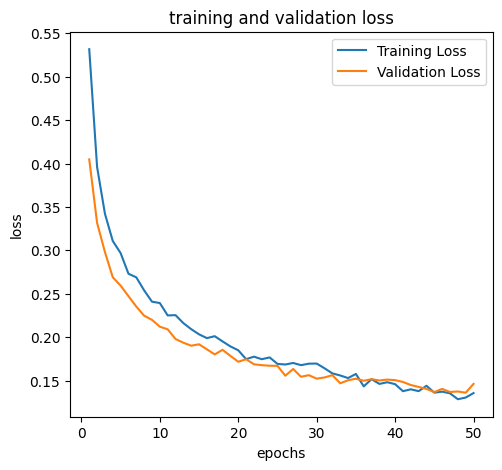

In [138]:
# loss 
plt.figure(figsize = (12,5))
plt.subplot(1,2,1)
plt.plot(range(1, NUM_EPOCHS +1), train_losses, label = 'Training Loss')
plt.plot(range(1, NUM_EPOCHS +1), val_losses, label = 'Validation Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('training and validation loss')
plt.legend()

Text(0.5, 1.0, 'training and validation acc')

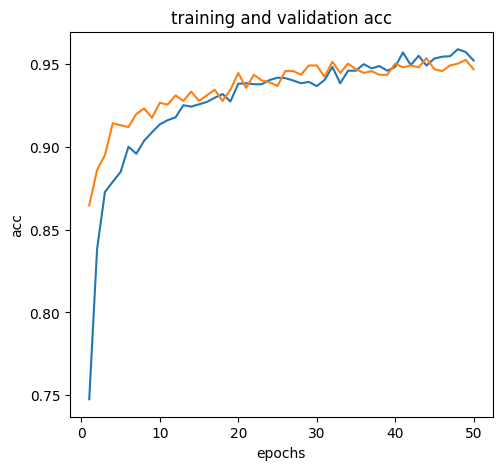

In [139]:
# accuracy
plt.figure(figsize = (12,5))
plt.subplot(1,2,1)
plt.plot(range(1, NUM_EPOCHS +1), train_accuracies, label = 'Training Accuracy')
plt.plot(range(1, NUM_EPOCHS +1), val_accuracies, label = 'Validation Accuracy')
plt.xlabel('epochs')
plt.ylabel('acc')
plt.title('training and validation acc')


In [142]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np 


              precision    recall  f1-score   support

    no_tumor       0.95      0.93      0.94       415
   yes_tumor       0.94      0.96      0.95       472

    accuracy                           0.95       887
   macro avg       0.95      0.95      0.95       887
weighted avg       0.95      0.95      0.95       887



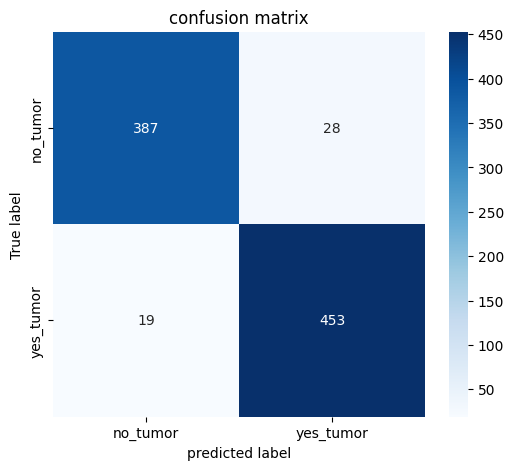

In [148]:
model.eval() ## eval mode on 

y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)

        outputs = model(inputs)
        preds = torch.round(torch.sigmoid(outputs))

        # list extending
        y_true.extend(labels.numpy())
        y_pred.extend(preds.cpu().numpy())


# classification report
print(f"{classification_report(y_true,y_pred, target_names = ['no_tumor','yes_tumor'])}")

# confusion matrix

cm = confusion_matrix(y_true,y_pred)

plt.figure(figsize = (6,5))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = ['no_tumor','yes_tumor'], yticklabels = ['no_tumor','yes_tumor'])

plt.xlabel('predicted label')
plt.ylabel('True label')
plt.title('confusion matrix')
plt.show()
        